In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## WGAN

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip

Download the LSUN scene classification dataset bedroom category, unzip it, and convert it to jpg files (the scripts folder is here in the `dl2` folder):

```
curl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o bedroom.zip
unzip bedroom.zip
pip install lmdb
python lsun-data.py {PATH}/bedroom_train_lmdb --out_dir {PATH}/bedroom
```

This isn't tested on Windows - if it doesn't work, you could use a Linux box to convert the files, then copy them over. Alternatively, you can download [this 20% sample](https://www.kaggle.com/jhoward/lsun_bedroom) from Kaggle datasets.

In [3]:
PATH = Path('./data/lsun/')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [5]:
# Optional - sampling a subset of files
#CSV_PATH = PATH/'files_sample.csv'

In [6]:
#files = PATH.glob('bedroom/**/*.jpg')

#with CSV_PATH.open('w') as fo:
    #for f in files:
        #if random.random()<0.1: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [8]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

NOTE ON 'DISCRIMINATOR' (source:  https://www.reddit.com/r/MachineLearning/comments/5qxoaz/r_170107875_wasserstein_gan/)

Indeed it's not called a discriminator because its purpose is not to discriminate :)

We decided to call it a critic with actor critic methods in RL in mind. There, the actor (in our case the generator) is directly trained with the output of the critic as a reward, instead of passing it through another loss term. The name change is not to be taken too seriously though (we even still call it netD in the code), we just thought 'critic' was a broader term than discriminator for our case, and that writing it like that in the paper made the difference in the training procedure clearer.

In [9]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [10]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [11]:
bs,sz,nz = 64,64,100

In [12]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'bedroom', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True, num_workers=16)

In [13]:
md = md.resize(128)

In [14]:
#TO get around bug for now, where files aren't being copied over to tmp 100%
files = TMP_PATH.glob('128/bedroom/**/*.jpg')
with CSV_PATH.open('w') as fo:
    for f in files: 
        fo.write(f'{f.relative_to(TMP_PATH)},0\n')

In [15]:
md = ImageClassifierData.from_csv(TMP_PATH, '', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True, num_workers=16)

In [16]:
x,_ = next(iter(md.val_dl))

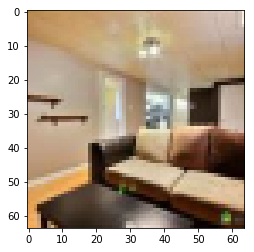

In [17]:
plt.imshow(md.trn_ds.denorm(x)[0]);

In [137]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [138]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))

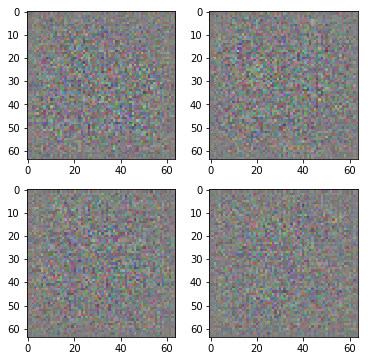

In [139]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

In [140]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [141]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [143]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                j = 0
                while (j < d_iters) and (i < n):
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                    real = V(next(data_iter)[0])
                    #Lower == Real
                    real_loss = netD(real)
                    fake = netG(create_noise(real.size(0)))
                    fake_loss = netD(V(fake.data))
                    netD.zero_grad()
                    lossD = real_loss-fake_loss
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                    
                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))).mean(0).view(1)
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            print(f'\nWDist {to_np(lossD)}; Real Score {to_np(real_loss)}; Fake Score {to_np(fake_loss)}; Gen Loss{to_np(lossG)}')

In [144]:
torch.backends.cudnn.benchmark=True

In [145]:
train(1, False)

100%|█████████▉| 2191/2192 [02:42<00:00, 16.31it/s]
WDist [-1.60934]; Real Score [-0.80494]; Fake Score [0.80441]; Gen Loss[0.98876]
100%|██████████| 1/1 [02:42<00:00, 162.53s/it]

In [146]:
fixed_noise = create_noise(bs)

In [148]:
set_trainable(netD, True)
set_trainable(netG, True)
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [149]:
for index in range(20):
    train(index, False)

0it [00:00, ?it/s]
100%|█████████▉| 2191/2192 [02:42<00:00, 17.30it/s]
WDist [-1.61353]; Real Score [-0.80659]; Fake Score [0.80694]; Gen Loss[0.82314]
100%|█████████▉| 2191/2192 [02:43<00:00, 16.58it/s]
WDist [-1.61392]; Real Score [-0.80722]; Fake Score [0.80669]; Gen Loss[0.82289]
100%|█████████▉| 2191/2192 [02:42<00:00, 16.52it/s]
WDist [-1.61251]; Real Score [-0.80635]; Fake Score [0.80617]; Gen Loss[0.82252]
100%|██████████| 2192/2192 [02:42<00:00, 17.14it/s]
WDist [-1.61314]; Real Score [-0.80693]; Fake Score [0.80621]; Gen Loss[0.8228]

  8%|▊         | 166/2192 [00:13<04:29,  7.53it/s]


KeyboardInterrupt: 

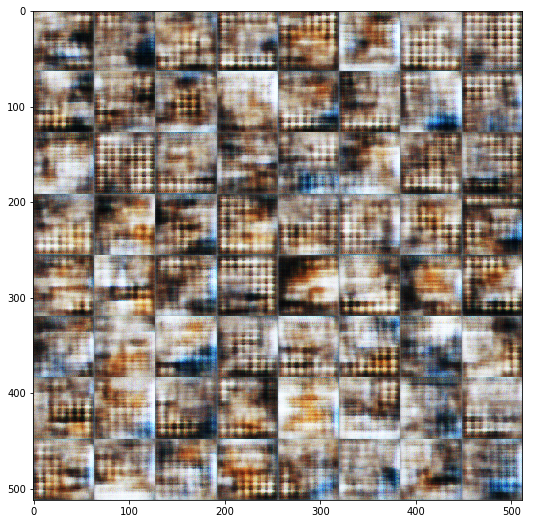

In [150]:
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [ ]:
torch.save(netG.state_dict(), TMP_PATH/'netG_2.h5')
torch.save(netD.state_dict(), TMP_PATH/'netD_2.h5')